In [1]:
import torch
from torch.nn import functional as F
from bitsandbytes import functional as bnbf
from auto_gptq.quantization import GPTQ
from transformers import AutoModelForCausalLM

torch.random.manual_seed(42)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/xinyu/anaconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA SETUP: CUDA runtime path found: /home/xinyu/anaconda3/envs/llm/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /home/xinyu/anaconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so...


2023-05-27 11:12:56.672160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 11:12:57.157762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class SimpleQuant:

    def __init__(self, bits=4):
        self.bits = bits

    def find_params(self, x):
        self.maxq = 2**self.bits -1 
        self.scale = (x.max() - x.min()) / self.maxq
        self.zero = round(-x.min().item() / self.scale.item())

    def quantize(self, x):
        r = torch.round(x / self.scale) + self.zero
        return torch.clamp(r, 0, self.maxq)

    def dequantize(self, x):
        return (x - self.zero) * self.scale

In [3]:
def parseint8(x):
    return (x >> 4) & 0b1111, x & 0b1111

## 1*64 Tensor Quant

In [4]:
x = torch.Tensor([0.2, 0.3, 0.7, 1.8]*16)
x = x.to("cuda")

### SimpleQuant To Int4

In [5]:
sq = SimpleQuant()
sq.find_params(x)

In [6]:
sq.quantize(x)[:4]

tensor([ 0.,  1.,  5., 15.], device='cuda:0')

In [7]:
sqx = sq.dequantize(sq.quantize(x))
sqx[:4]

tensor([0.2133, 0.3200, 0.7467, 1.8133], device='cuda:0')

In [8]:
sqb = F.mse_loss(x, sqx)
sqb

tensor(0.0007, device='cuda:0')

In [9]:
def sqi4(x):
    sq = SimpleQuant()
    sq.find_params(x)
    
    print(f"Quant: {sq.quantize(x)[:4]}")

    sqx = sq.dequantize(sq.quantize(x))
    print(f"Dequant: {sqx[:4]}")
    
    sqb = F.mse_loss(x, sqx).item()
    print(f"Loss: {sqb}")
    return sqb

### Quant to FP4

In [10]:
fp4q, fp4qs = bnbf.quantize_fp4(x)
[vv.item() for v in fp4q[:2] for vv in parseint8(v)]

[6, 6, 4, 3]

In [11]:
fp4qx = bnbf.dequantize_fp4(fp4q, fp4qs)
fp4qx[:4]

tensor([0.3000, 0.3000, 0.6000, 1.8000], device='cuda:0')

In [12]:
fp4qb = F.mse_loss(x, fp4qx)
fp4qb

tensor(0.0050, device='cuda:0')

In [13]:
def qfp4(x):
    fp4q, fp4qs = bnbf.quantize_fp4(x)
    quant_v = [vv.item() for v in fp4q[:2] for vv in parseint8(v)]
    print(f"Quant: {quant_v}")
    
    fp4qx = bnbf.dequantize_fp4(fp4q, fp4qs)
    print(f"Dequant: {fp4qx[:4]}")
    
    fp4qb = F.mse_loss(x, fp4qx).item()
    print(f"Loss: {fp4qb}")
    return fp4qb

### Quant to NF4

In [14]:
nf4q, nf4qs = bnbf.quantize_nf4(x)
[vv.item() for v in nf4q[:2] for vv in parseint8(v)]

[8, 9, 11, 15]

In [15]:
nf4qx = bnbf.dequantize_fp4(nf4q, nf4qs)
nf4qx[:4]

tensor([0.1432, 0.2897, 0.6082, 1.8000], device='cuda:0')

In [16]:
nf4qb = F.mse_loss(x, nf4qx)
nf4qb

tensor(0.0029, device='cuda:0')

In [17]:
def qnf4(x):
    nf4q, nf4qs = bnbf.quantize_nf4(x)
    quant_v = [vv.item() for v in nf4q[:2] for vv in parseint8(v)]
    print(f"Quant: {quant_v}")

    nf4qx = bnbf.dequantize_fp4(nf4q, nf4qs)
    print(f"Dequant: {nf4qx[:4]}")

    nf4qb = F.mse_loss(x, nf4qx).item()
    print(f"Loss: {nf4qb}")
    return nf4qb

### Compare

In [18]:
x_allpos = torch.rand(64).to("cuda")
x_negpos = (torch.rand(64) - torch.rand(64).mean()).to("cuda")
x_nomal = torch.normal(torch.rand(64)).to("cuda")

x_list = [x_allpos, x_negpos, x_nomal]
q_func = [sqi4, qfp4, qnf4]

In [19]:
%%capture
plt_data = [[f(x) for x in x_list] for f in q_func]

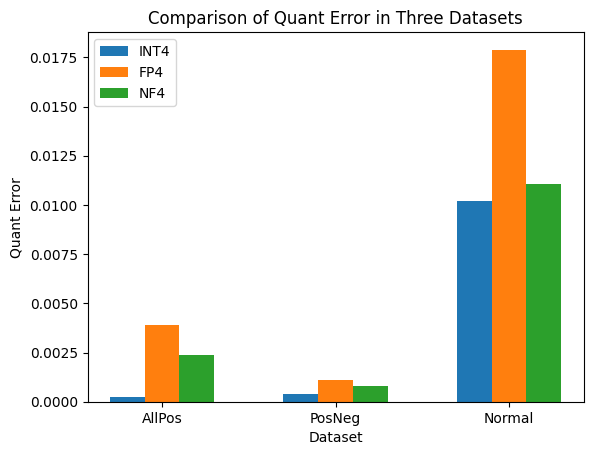

In [20]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(plt_data[0]))

width = 0.2
plt.bar(x - width, plt_data[0], width, label='INT4')
plt.bar(x, plt_data[1], width, label='FP4')
plt.bar(x + width, plt_data[2], width, label='NF4')

plt.title('Comparison of Quant Error in Three Datasets')
plt.xlabel('Dataset')
plt.ylabel('Quant Error')
plt.xticks(x, ['AllPos', 'PosNeg', 'Normal'])
plt.legend(loc='upper left')

plt.show()

## Quant OPT-125m

In [21]:
def get_layer_by_name(model, layer_name):
    for name, module in model.named_modules():
        if name == layer_name:
            return module
    raise Exception(f"no layer named {layer_name}")

### Get Layer to Quant

In [22]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-125m")

layer = get_layer_by_name(model, "model.decoder.layers.0.fc2")
layer = layer.to("cuda")
weight_c = layer.weight.clone()

### Quant With simple int4, fp4, nf4

In [23]:
sqi4_loss = sqi4(weight_c)

Quant: tensor([[8., 8., 8.,  ..., 8., 8., 8.],
        [8., 8., 8.,  ..., 8., 8., 8.],
        [8., 8., 8.,  ..., 8., 8., 8.],
        [8., 8., 8.,  ..., 8., 8., 8.]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Dequant: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Loss: 0.0005981011781841516


In [24]:
qfp4_loss = qfp4(weight_c)

Quant: [4, 9, 9, 4]
Dequant: tensor([[ 0.0271, -0.0004, -0.0004,  ...,  0.0003,  0.0266, -0.0266],
        [-0.0191, -0.0143,  0.0287,  ...,  0.0004, -0.0391, -0.0004],
        [ 0.0172, -0.0086,  0.0343,  ..., -0.0101, -0.0101, -0.0003],
        [ 0.0156,  0.0156,  0.0156,  ...,  0.0122, -0.0183, -0.0122]],
       device='cuda:0')
Loss: 1.2598326975421514e-05


In [25]:
qnf4_loss = qnf4(weight_c)

Quant: [12, 7, 7, 11]
Dequant: tensor([[ 0.0358,  0.0000,  0.0000,  ...,  0.0000,  0.0300, -0.0280],
        [-0.0226, -0.0106,  0.0322,  ...,  0.0000, -0.0309, -0.0071],
        [ 0.0174, -0.0095,  0.0289,  ..., -0.0112, -0.0055, -0.0055],
        [ 0.0074,  0.0074,  0.0151,  ...,  0.0118, -0.0209, -0.0067]],
       device='cuda:0')
Loss: 6.642355856456561e-06


### Quant With GPTQ

In [26]:
gptq = GPTQ(layer)

In [27]:
with torch.no_grad():
    inp = torch.rand(10000, layer.in_features).to("cuda")
    out = layer(inp)
gptq.add_batch(inp, out)

In [28]:
gptq.quantizer.configure(4, perchannel=True)

In [29]:
_ = gptq.fasterquant()

In [30]:
gptq_loss = F.mse_loss(weight_c, gptq.layer.weight.data)
gptq_loss

tensor(3.9272e-05, device='cuda:0', grad_fn=<MseLossBackward0>)

In [31]:
def qgptq(layer):
    weight_copy = layer.weight.clone()
    gptq = GPTQ(layer)
    with torch.no_grad():
        inp = torch.rand(10000, layer.in_features).to("cuda")
        out = layer(inp)
    gptq.add_batch(inp, out)
    gptq.quantizer.configure(4, perchannel=True)
    _ = gptq.fasterquant()
    return F.mse_loss(weight_copy, gptq.layer.weight.data).item()

### Compare
Considering that the performance of simple quant is relatively poor, and GPTQ itself is an upgraded version of simple quant, sq no longer participates in the comparison

In [32]:
layer_names = [
    "model.decoder.layers.6.self_attn.q_proj",
    "model.decoder.layers.6.self_attn.k_proj",
    "model.decoder.layers.6.self_attn.v_proj",
    "model.decoder.layers.6.self_attn.out_proj",
    "model.decoder.layers.6.fc1",
    "model.decoder.layers.6.fc2",
]

layers = [get_layer_by_name(model, n).to("cuda") for n in layer_names]

In [33]:
%%capture
fp4error = [qfp4(l.weight) for l in layers]
nf4error = [qnf4(l.weight) for l in layers]
gptqerror = [qgptq(l) for l in layers]

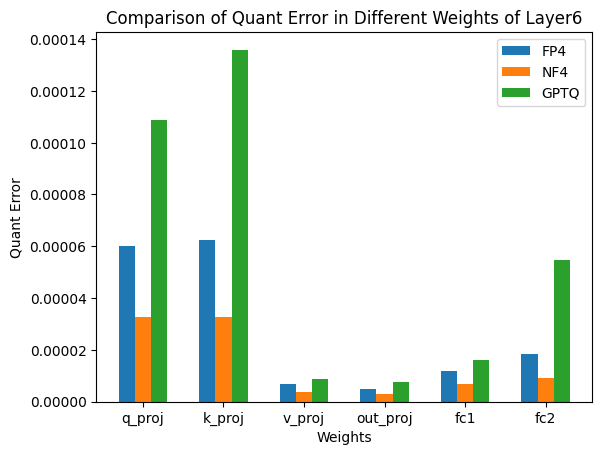

In [34]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(fp4error))

width = 0.2
plt.bar(x - width, fp4error, width, label='FP4')
plt.bar(x, nf4error, width, label='NF4')
plt.bar(x + width, gptqerror, width, label='GPTQ')

plt.title('Comparison of Quant Error in Different Weights of Layer6')
plt.xlabel('Weights')
plt.ylabel('Quant Error')
plt.xticks(x, ['q_proj', 'k_proj', 'v_proj', 'out_proj', 'fc1', "fc2"])
plt.legend(loc='upper right')

plt.show()